**Task: Create FPR/FNR/Accuracy graphs for different mixing rates for the Folktable**


Custom Prediction Task: ACSIncomeNew 

In [3]:
import numpy as np
import pandas as pd

import folktables
ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', # Age (1-99)
        'COW', # Class of Worker (1-9)
        'SCHL', # Education (1-24)
        'MAR', # Marital status (1-5)
        'OCCP', # Occupation 0000-9920
        'POBP', # Place of birth 000-554
        'RELP', ## Relationship (00-17)
        'WKHP',# Hours worked per week (0-99)
        'SEX', # sex (1,2)
        'RAC1P', # race (1-9)
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

Variables mapped to columns of features in X_test

In [216]:
mf_values = X_test[:,8] 
mf_values

array([1., 1., 2., ..., 1., 1., 2.])

In [223]:
agep = X_test[:,0] # Age (1-99)
agep

array([62., 33., 33., ..., 34., 58., 64.])

In [224]:
cow = X_test[:,1] # Class of Worker (1-9)
cow

array([1., 7., 1., ..., 1., 3., 6.])

In [238]:
mar = X_test[:,3] # Marital status (1-5)
mar, mar.shape

# for entry in mar:
#     if(entry == 5 ):
#         print(entry)

(array([1., 1., 5., ..., 1., 5., 1.]), (58700,))

In [225]:
occp = X_test[:,4]  # Occupation 0000-9920
occp

array([5840., 4700.,  800., ..., 4750., 3870., 2100.])

In [257]:
pobp = X_test[:,5] # Place of birth 000-554
pobp
# for entry in pobp:
#     if(entry == 200 ):
#         print(entry)

array([21., 32.,  6., ...,  6., 34., 42.])

In [261]:
relp = X_test[:,6] ## Relationship (00-17)
relp
# for entry in occp:
#     if(entry == 5 ):
#         print(entry)

array([1., 1., 0., ..., 0., 0., 1.])

In [262]:
wkhp = X_test[:,7]# Hours worked per week (0-99)
wkhp
# for entry in wkhp:
#     if(entry == 199):
#         print(entry)

array([40., 65., 40., ..., 40., 20.,  5.])

In [263]:
sex = X_test[:,8] # sex (1,2)
sex

array([1., 1., 2., ..., 1., 1., 2.])

In [264]:
rac1p = X_test[:,9]  # race (1-9)
rac1p

array([1., 1., 1., ..., 8., 2., 1.])

In [267]:
X_train, X_train.shape

(array([[24.,  1., 21., ..., 40.,  2.,  2.],
        [51.,  1., 22., ..., 40.,  2.,  1.],
        [41.,  1., 16., ..., 40.,  2.,  1.],
        ...,
        [60.,  1., 21., ..., 60.,  1.,  6.],
        [47.,  3., 22., ..., 60.,  1.,  1.],
        [58.,  3., 16., ..., 30.,  2.,  8.]]),
 (136965, 10))

In [123]:
X_test[:, 0] # AGEP

array([62., 33., 33., ..., 34., 58., 64.])

In [121]:
acs_ca['PINCP']

0         48500.0
1             0.0
2         13100.0
3             0.0
4             0.0
           ...   
378812     2400.0
378813    30000.0
378814        0.0
378815        0.0
378816        0.0
Name: PINCP, Length: 378817, dtype: float64

In [164]:
target_value = 13100.0
found = False

for col_index in range(X_test.shape[1]):  # Loop through columns
    column = X_test[:, col_index]
    indices = np.where(column == target_value)[0]

    if indices.size > 0:  # Check if the target_value is found in the column
        found = True
        print(f"Found {target_value} in column {col_index} at indices:", indices)
        break

if not found:
    print(f"{target_value} not found in any column.")


13100.0 not found in any column.


In [5]:
pred_label = 'PINCP'
pincp = acs_ca[[pred_label]]


In [6]:
pincp

,PINCP
0,48500.0
1,0.0
2,13100.0
3,0.0
4,0.0
...,...
378812,2400.0
378813,30000.0
378814,0.0
378815,0.0


In [7]:
acs_ca.iloc[0]

RT                      P
SERIALNO    2018GQ0000004
DIVISION                9
SPORDER                 1
PUMA                 3701
                ...      
PWGTP76                59
PWGTP77                33
PWGTP78                 8
PWGTP79                58
PWGTP80                32
Name: 0, Length: 286, dtype: object

In [10]:
x_labels = ACSIncomeNew.features

In [11]:
x_labels

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']

In [13]:
X = acs_ca[x_labels]

In [14]:
X.shape

(378817, 10)

In [15]:
X

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30,6.0,14.0,1,9610.0,6,16,40.0,1,8
1,18,NaN,14.0,5,NaN,6,17,NaN,2,1
2,69,NaN,17.0,1,NaN,6,17,NaN,1,9
3,25,NaN,1.0,5,NaN,4,17,NaN,1,1
4,31,NaN,18.0,5,NaN,6,16,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...
378812,61,1.0,21.0,1,5740.0,240,1,NaN,2,6
378813,40,1.0,17.0,1,9600.0,303,0,40.0,1,8
378814,43,NaN,16.0,1,NaN,303,1,NaN,2,8
378815,23,NaN,16.0,5,NaN,6,2,NaN,1,8


In [17]:
y = acs_ca[pred_label]

In [18]:
y

0         48500.0
1             0.0
2         13100.0
3             0.0
4             0.0
           ...   
378812     2400.0
378813    30000.0
378814        0.0
378815        0.0
378816        0.0
Name: PINCP, Length: 378817, dtype: float64

In [19]:
y.shape

(378817,)

In [102]:
X_test

array([[62.,  1., 18., ..., 40.,  1.,  1.],
       [33.,  7., 21., ..., 65.,  1.,  1.],
       [33.,  1., 21., ..., 40.,  2.,  1.],
       ...,
       [34.,  1., 16., ..., 40.,  1.,  8.],
       [58.,  3., 21., ..., 20.,  1.,  2.],
       [64.,  6., 23., ...,  5.,  2.,  1.]])

In [104]:
acs_ca['SERIALNO']

0         2018GQ0000004
1         2018GQ0000013
2         2018GQ0000016
3         2018GQ0000020
4         2018GQ0000027
              ...      
378812    2018HU1400891
378813    2018HU1400893
378814    2018HU1400893
378815    2018HU1400893
378816    2018HU1400893
Name: SERIALNO, Length: 378817, dtype: object

In [21]:
acs_ca[acs_ca['SEX']==1] # Male

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000004,9,1,3701,4,6,1013097,32,30,...,34,60,60,7,8,59,33,8,58,32
2,P,2018GQ0000016,9,1,3755,4,6,1013097,109,69,...,105,232,226,110,114,217,2,111,2,106
3,P,2018GQ0000020,9,1,7319,4,6,1013097,34,25,...,67,0,34,34,69,0,34,35,0,0
5,P,2018GQ0000039,9,1,101,4,6,1013097,48,19,...,50,49,48,87,49,49,50,11,49,87
6,P,2018GQ0000045,9,1,106,4,6,1013097,52,21,...,52,52,91,93,52,52,54,94,13,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378809,P,2018HU1400886,9,1,1304,4,6,1013097,73,72,...,116,72,111,21,83,128,121,74,75,67
378811,P,2018HU1400891,9,1,1308,4,6,1013097,78,69,...,23,69,21,142,71,23,21,62,68,81
378813,P,2018HU1400893,9,1,7108,4,6,1013097,172,40,...,173,53,288,47,199,181,164,178,176,154
378815,P,2018HU1400893,9,3,7108,4,6,1013097,172,23,...,178,56,297,56,189,167,167,177,180,155


In [22]:
acs_ca[acs_ca['SEX']==2] # Female

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10
8,P,2018GQ0000065,9,1,5909,4,6,1013097,124,55,...,123,139,119,250,123,120,2,2,251,130
12,P,2018GQ0000086,9,1,7506,4,6,1013097,21,19,...,35,37,4,21,20,4,20,4,20,6
13,P,2018GQ0000100,9,1,3711,4,6,1013097,106,18,...,23,188,103,190,105,23,109,23,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378804,P,2018HU1400858,9,1,8103,4,6,1013097,64,45,...,102,61,72,15,68,21,17,107,110,58
378808,P,2018HU1400875,9,2,5904,4,6,1013097,99,39,...,177,108,28,30,111,114,29,171,90,106
378810,P,2018HU1400886,9,2,1304,4,6,1013097,75,72,...,135,78,112,20,83,131,120,71,77,73
378812,P,2018HU1400891,9,2,1308,4,6,1013097,94,61,...,26,77,21,171,86,31,25,82,82,106


In [23]:
acs_ca[acs_ca['SEX']==1].shape

(186677, 286)

In [24]:
acs_ca[acs_ca['SEX']==2].shape

(192140, 286)

In [39]:
x_labels

['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']

In [42]:
acs_ca.shape

(378817, 286)

In [46]:
acs_ca[acs_ca['SEX']==2]

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
1,P,2018GQ0000013,9,1,7306,4,6,1013097,45,18,...,0,0,0,91,46,46,0,89,45,0
4,P,2018GQ0000027,9,1,6511,4,6,1013097,46,31,...,47,81,10,11,79,47,44,81,47,10
8,P,2018GQ0000065,9,1,5909,4,6,1013097,124,55,...,123,139,119,250,123,120,2,2,251,130
12,P,2018GQ0000086,9,1,7506,4,6,1013097,21,19,...,35,37,4,21,20,4,20,4,20,6
13,P,2018GQ0000100,9,1,3711,4,6,1013097,106,18,...,23,188,103,190,105,23,109,23,183,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378804,P,2018HU1400858,9,1,8103,4,6,1013097,64,45,...,102,61,72,15,68,21,17,107,110,58
378808,P,2018HU1400875,9,2,5904,4,6,1013097,99,39,...,177,108,28,30,111,114,29,171,90,106
378810,P,2018HU1400886,9,2,1304,4,6,1013097,75,72,...,135,78,112,20,83,131,120,71,77,73
378812,P,2018HU1400891,9,2,1308,4,6,1013097,94,61,...,26,77,21,171,86,31,25,82,82,106


In [45]:
acs_data['COW']

0        1.0
1        1.0
2        5.0
3        NaN
4        1.0
        ... 
28112    1.0
28113    NaN
28114    NaN
28115    NaN
28116    1.0
Name: COW, Length: 3236107, dtype: float64

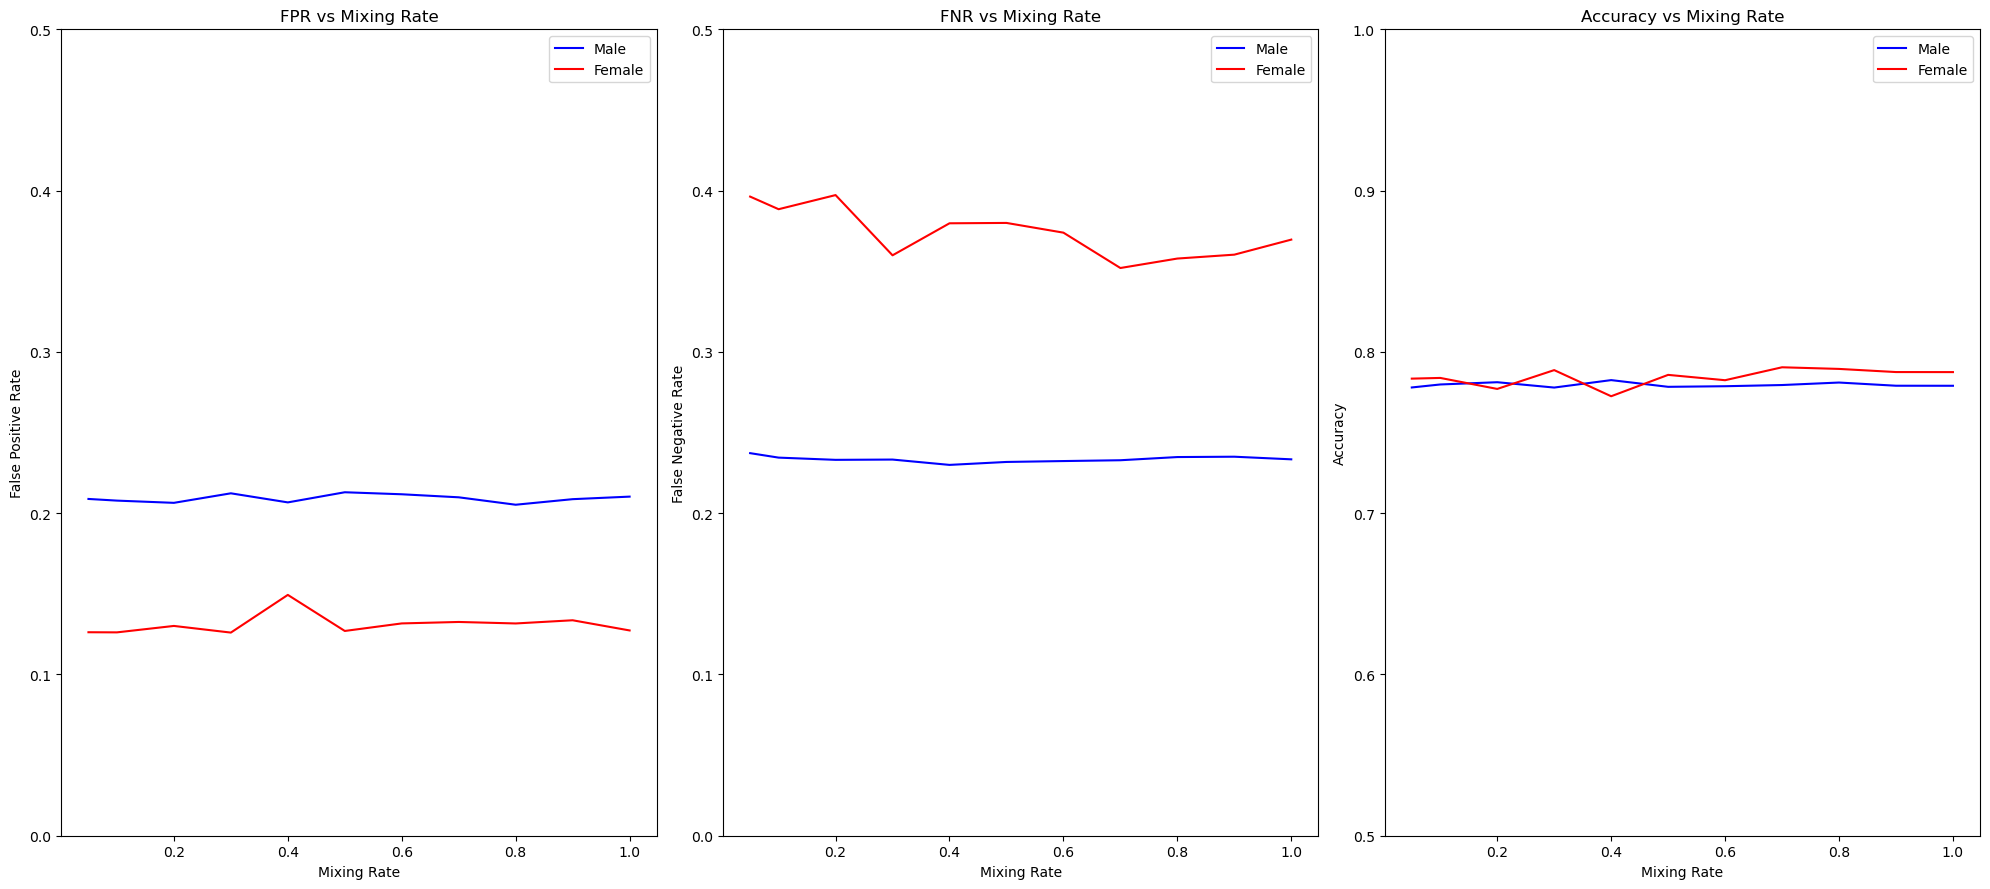

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import folktables

def calculate_metrics(y_true, y_pred):
    # Check if the confusion matrix is empty
    if np.sum(y_true == 1) == 0 or np.sum(y_true == 0) == 0:
        fpr, fnr, acc = np.nan, np.nan, np.nan
    else:
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Extract values from the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        acc = accuracy_score(y_true, y_pred)
    return fpr, fnr, acc

ACSIncomeNew = folktables.BasicProblem(
    features=[
        'AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='SEX',
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

def evaluate_model_with_mixing_rate(mixing_rate, features, labels, groups):
    # Adjust the mixing rate by subsampling the 'female' group
    female_indices = np.where(groups == 2)[0]
    num_female_to_keep = int(len(female_indices) * mixing_rate)
    subsampled_female_indices = np.random.choice(female_indices, size=num_female_to_keep, replace=False)

    # Create the modified dataset
    modified_features = np.concatenate([features[groups == 1], features[subsampled_female_indices]])
    modified_labels = np.concatenate([labels[groups == 1], labels[subsampled_female_indices]])
    modified_groups = np.concatenate([groups[groups == 1], groups[subsampled_female_indices]])

    # Split the modified dataset into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        modified_features, modified_labels, modified_groups, test_size=0.2, random_state=0)

    # Create and fit the model
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate FPR, FNR, and Accuracy for male (group = 1) and female (group = 2)
    fpr_male, fnr_male, acc_male = calculate_metrics(y_test[group_test == 1], y_pred[group_test == 1])
    fpr_female, fnr_female, acc_female = calculate_metrics(y_test[group_test == 2], y_pred[group_test == 2])

    return fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_ca = data_source.get_data(states=["CA"], download=True)
ca_features, ca_label, ca_group = ACSIncomeNew.df_to_numpy(acs_ca)

# Split data for training
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    ca_features, ca_label, ca_group, test_size=0.3, random_state=0)

# Train the model
model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

mixing_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results = {'Mixing Rate': [], 'FPR Male': [], 'FNR Male': [], 'Accuracy Male': [],
           'FPR Female': [], 'FNR Female': [], 'Accuracy Female': []}

for mixing_rate in mixing_rates:
    fpr_male, fnr_male, acc_male, fpr_female, fnr_female, acc_female = evaluate_model_with_mixing_rate(
        mixing_rate, ca_features, ca_label, ca_group)
    
    results['Mixing Rate'].append(mixing_rate)
    results['FPR Male'].append(fpr_male)
    results['FNR Male'].append(fnr_male)
    results['Accuracy Male'].append(acc_male)
    results['FPR Female'].append(fpr_female)
    results['FNR Female'].append(fnr_female)
    results['Accuracy Female'].append(acc_female)

# Save results to a DataFrame
results_df = pd.DataFrame(results)
results_df

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 9))  # Use 1 row and 3 columns

axs[0].plot(results_df['Mixing Rate'], results_df['FPR Male'], label='Male', color='blue')
axs[0].plot(results_df['Mixing Rate'], results_df['FPR Female'], label='Female', color='red')
axs[0].set_xlabel('Mixing Rate')
axs[0].set_ylabel('False Positive Rate')
axs[0].set_title('FPR vs Mixing Rate')
axs[0].legend()
axs[0].set_ylim(0, 0.5)

axs[1].plot(results_df['Mixing Rate'], results_df['FNR Male'], label='Male', color='blue')
axs[1].plot(results_df['Mixing Rate'], results_df['FNR Female'], label='Female', color='red')
axs[1].set_xlabel('Mixing Rate')
axs[1].set_ylabel('False Negative Rate')
axs[1].set_title('FNR vs Mixing Rate')
axs[1].legend()
axs[1].set_ylim(0, 0.5)

axs[2].plot(results_df['Mixing Rate'], results_df['Accuracy Male'], label='Male', color='blue')
axs[2].plot(results_df['Mixing Rate'], results_df['Accuracy Female'], label='Female', color='red')
axs[2].set_xlabel('Mixing Rate')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy vs Mixing Rate')
axs[2].legend()
axs[2].set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [60]:
results_df

,Mixing Rate,FPR Male,FNR Male,Accuracy Male,FPR Female,FNR Female,Accuracy Female
0,0.001,0.205882,0.236861,0.779709,0.076923,0.555556,0.727273
1,0.100,0.207784,0.234338,0.779845,0.136578,0.377709,0.782292
2,0.200,0.207128,0.232958,0.780854,0.129193,0.348978,0.793094
3,0.300,0.212130,0.233133,0.778031,0.130423,0.348671,0.793004
4,0.400,0.206410,0.229097,0.783032,0.124391,0.354682,0.792394
5,0.500,0.212332,0.231756,0.778681,0.133149,0.363921,0.787992
6,0.600,0.212171,0.232519,0.778368,0.132078,0.369119,0.786713
7,0.700,0.209742,0.233025,0.779400,0.133831,0.361191,0.786678
8,0.800,0.205324,0.235417,0.780657,0.131756,0.354131,0.790386
9,0.900,0.209044,0.235319,0.778679,0.130727,0.361826,0.788632
